In [3]:
import cv2
import numpy as np
import _pickle as cPickle
from sklearn.cluster import MiniBatchKMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


Let us first read the train and test files

In [4]:
train_images_filenames = cPickle.load(open('train_images_filenames.dat','rb'))
test_images_filenames = cPickle.load(open('test_images_filenames.dat','rb'))
train_labels = cPickle.load(open('train_labels.dat','rb'))
test_labels = cPickle.load(open('test_labels.dat','rb'))


In [5]:
train_images_filenames[12]

'../../Databases/MIT_split/train/Opencountry/fie26.jpg'

We create a SIFT object detector and descriptor

In [6]:
SIFTdetector = cv2.xfeatures2d.SIFT_create(nfeatures=300)

We compute the SIFT descriptors for all the train images and subsequently build a numpy array with all the descriptors stacked together

In [7]:

Train_descriptors = []
Train_label_per_descriptor = []

for filename,labels in zip(train_images_filenames,train_labels):
    ima=cv2.imread(filename)
    gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
    kpt,des=SIFTdetector.detectAndCompute(gray,None)
    Train_descriptors.append(des)
    Train_label_per_descriptor.append(labels)

D=np.vstack(Train_descriptors)


We now compute a k-means clustering on the descriptor space

In [8]:
k = 128
codebook = MiniBatchKMeans(n_clusters=k, verbose=False, batch_size=k * 20,compute_labels=False,reassignment_ratio=10**-4,random_state=42)
codebook.fit(D)

MiniBatchKMeans(batch_size=2560, compute_labels=False, n_clusters=128,
                random_state=42, reassignment_ratio=0.0001, verbose=False)

And, for each train image, we project each keypoint descriptor to its closest visual word. We represent each of the images with the frequency of each visual word.

In [9]:
visual_words=np.zeros((len(Train_descriptors),k),dtype=np.float32)
for i in range(len(Train_descriptors)):
    words=codebook.predict(Train_descriptors[i])
    visual_words[i,:]=np.bincount(words,minlength=k)

We build a k-nn classifier and train it with the train descriptors

In [10]:
knn = KNeighborsClassifier(n_neighbors=5,n_jobs=-1,metric='euclidean')
knn.fit(visual_words, train_labels) 

KNeighborsClassifier(metric='euclidean', n_jobs=-1)

We end up computing the test descriptors and compute the accuracy of the model

In [11]:
visual_words_test=np.zeros((len(test_images_filenames),k),dtype=np.float32)
for i in range(len(test_images_filenames)):
    filename=test_images_filenames[i]
    ima=cv2.imread(filename)
    gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
    kpt,des=SIFTdetector.detectAndCompute(gray,None)
    words=codebook.predict(des)
    visual_words_test[i,:]=np.bincount(words,minlength=k)

In [12]:
accuracy = 100*knn.score(visual_words_test, test_labels)
print(accuracy)

53.53159851301115


Dimensionality reduction, with PCA and LDA

In [13]:
pca = PCA(n_components=64)
VWpca = pca.fit_transform(visual_words)
knnpca = KNeighborsClassifier(n_neighbors=5,n_jobs=-1,metric='euclidean')
knnpca.fit(VWpca, train_labels) 
vwtestpca = pca.transform(visual_words_test)
accuracy = 100*knnpca.score(vwtestpca, test_labels)
print(accuracy)

53.77942998760843


In [14]:
lda = LinearDiscriminantAnalysis()
VWlda = lda.fit_transform(visual_words,train_labels)
knnlda = KNeighborsClassifier(n_neighbors=5,n_jobs=-1,metric='euclidean')
knnlda.fit(VWlda, train_labels) 
vwtestlda = lda.transform(visual_words_test)
accuracy = 100*knnlda.score(vwtestlda, test_labels)
print(accuracy)

59.727385377943


Now we repeat the previous steps, but in this case we compute the accuracy by varying the codebook sizes.

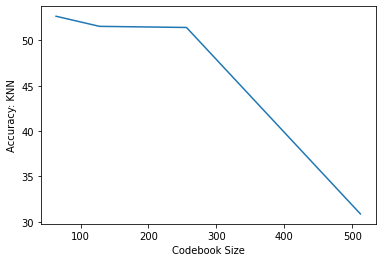

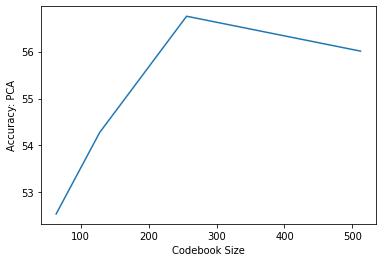

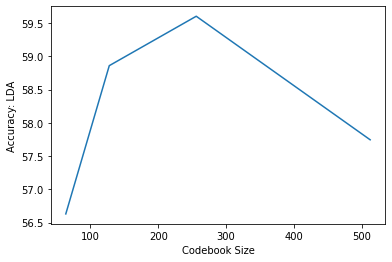

In [13]:
clusters = [64,128,256,512]
knn_acc = []
kpca_acc = []
klda_acc = []
for k in clusters:
    codebook = MiniBatchKMeans(n_clusters=k, verbose=False, batch_size=k * 20,compute_labels=False,reassignment_ratio=10**-4,random_state=42)
    codebook.fit(D)
    visual_words=np.zeros((len(Train_descriptors),k),dtype=np.float32)
    for i in range(len(Train_descriptors)):
        words=codebook.predict(Train_descriptors[i])
        visual_words[i,:]=np.bincount(words,minlength=k)

    knn = KNeighborsClassifier(n_neighbors=5,n_jobs=-1,metric='euclidean')
    knn.fit(visual_words, train_labels)

    visual_words_test=np.zeros((len(test_images_filenames),k),dtype=np.float32)
    for i in range(len(test_images_filenames)):
        filename=test_images_filenames[i]
        ima=cv2.imread(filename)
        gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
        kpt,des=SIFTdetector.detectAndCompute(gray,None)
        words=codebook.predict(des)
        visual_words_test[i,:]=np.bincount(words,minlength=k)

    accuracy = 100*knn.score(visual_words_test, test_labels)
    knn_acc.append(accuracy)

    pca = PCA(n_components=64)
    VWpca = pca.fit_transform(visual_words)
    knnpca = KNeighborsClassifier(n_neighbors=5,n_jobs=-1,metric='euclidean')
    knnpca.fit(VWpca, train_labels) 
    vwtestpca = pca.transform(visual_words_test)
    accuracy = 100*knnpca.score(vwtestpca, test_labels)
    kpca_acc.append(accuracy)

    lda = LinearDiscriminantAnalysis()
    VWlda = lda.fit_transform(visual_words,train_labels)
    knnlda = KNeighborsClassifier(n_neighbors=5,n_jobs=-1,metric='euclidean')
    knnlda.fit(VWlda, train_labels) 
    vwtestlda = lda.transform(visual_words_test)
    accuracy = 100*knnlda.score(vwtestlda, test_labels)
    klda_acc.append(accuracy)
    
import matplotlib.pyplot as plt

plt.plot(clusters,knn_acc)
plt.ylabel('Accuracy: KNN')
plt.xlabel('Codebook Size')
plt.show()

plt.plot(clusters,kpca_acc)
plt.ylabel('Accuracy: PCA')
plt.xlabel('Codebook Size')
plt.show()

plt.plot(clusters,klda_acc)
plt.ylabel('Accuracy: LDA')
plt.xlabel('Codebook Size')
plt.show()



We can see that the accurracy is optimal at Codebook size 256.

Now we repeat the previous steps, but in this case we compute the accuracy by varying the k in knn classifier size.

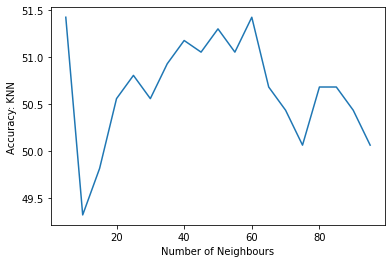

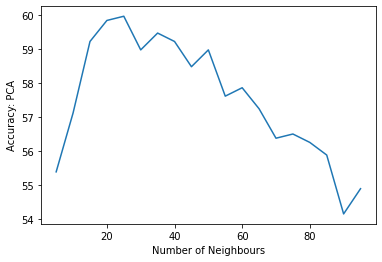

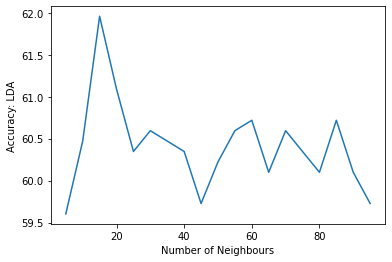

In [14]:
k = 256
codebook = MiniBatchKMeans(n_clusters=k, verbose=False, batch_size=k * 20,compute_labels=False,reassignment_ratio=10**-4,random_state=42)
codebook.fit(D)
visual_words=np.zeros((len(Train_descriptors),k),dtype=np.float32)
for i in range(len(Train_descriptors)):
    words=codebook.predict(Train_descriptors[i])
    visual_words[i,:]=np.bincount(words,minlength=k)
    
visual_words_test=np.zeros((len(test_images_filenames),k),dtype=np.float32)
for i in range(len(test_images_filenames)):
    filename=test_images_filenames[i]
    ima=cv2.imread(filename)
    gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
    kpt,des=SIFTdetector.detectAndCompute(gray,None)
    words=codebook.predict(des)
    visual_words_test[i,:]=np.bincount(words,minlength=k)

neighbours = range(5,100, 5)
knn_acc = []
kpca_acc = []
klda_acc = []
for n in neighbours:
    knn = KNeighborsClassifier(n_neighbors=n,n_jobs=-1,metric='euclidean')
    knn.fit(visual_words, train_labels)

    accuracy = 100*knn.score(visual_words_test, test_labels)
    knn_acc.append(accuracy)

    pca = PCA(n_components=64)
    VWpca = pca.fit_transform(visual_words)
    knnpca = KNeighborsClassifier(n_neighbors=n,n_jobs=-1,metric='euclidean')
    knnpca.fit(VWpca, train_labels) 
    vwtestpca = pca.transform(visual_words_test)
    accuracy = 100*knnpca.score(vwtestpca, test_labels)
    kpca_acc.append(accuracy)

    lda = LinearDiscriminantAnalysis()
    VWlda = lda.fit_transform(visual_words,train_labels)
    knnlda = KNeighborsClassifier(n_neighbors=n,n_jobs=-1,metric='euclidean')
    knnlda.fit(VWlda, train_labels) 
    vwtestlda = lda.transform(visual_words_test)
    accuracy = 100*knnlda.score(vwtestlda, test_labels)
    klda_acc.append(accuracy)
    
import matplotlib.pyplot as plt

plt.plot(neighbours,knn_acc)
plt.ylabel('Accuracy: KNN')
plt.xlabel('Number of Neighbours')
plt.show()

plt.plot(neighbours,kpca_acc)
plt.ylabel('Accuracy: PCA')
plt.xlabel('Number of Neighbours')
plt.show()

plt.plot(neighbours,klda_acc)
plt.ylabel('Accuracy: LDA')
plt.xlabel('Number of Neighbours')
plt.show()



Now we repeat the previous steps, but in this case we compute the keypoints with DENSE method, by default we initialize
the keypoint detector with 20 pixels width. The key points are separated by 20 pixels and we compute the keypoints with 5
different scales.

After this, we will compare the accuracy between SIFT keypoints and DENSE keypoints.

In [2]:
%reset -f
import cv2
import numpy as np
import _pickle as cPickle
from sklearn.cluster import MiniBatchKMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

train_images_filenames = cPickle.load(open('train_images_filenames.dat','rb'))
test_images_filenames = cPickle.load(open('test_images_filenames.dat','rb'))
train_labels = cPickle.load(open('train_labels.dat','rb'))
test_labels = cPickle.load(open('test_labels.dat','rb'))

class DenseDetector():
    def __init__(self, step_size=20, feature_scale=20, img_bound=20):
        # Create a dense feature detector
        self.initXyStep = step_size
        self.initFeatureScale = feature_scale
        self.initImgBound = img_bound

    def detect(self, img):
        keypoints = []
        rows, cols = img.shape[:2]
        for x in range(self.initImgBound, rows, self.initFeatureScale):
            for y in range(self.initImgBound, cols, self.initFeatureScale):
                keypoints.append(cv2.KeyPoint(float(x), float(y), self.initXyStep))
        return keypoints

SIFTdetector = cv2.xfeatures2d.SIFT_create(nfeatures=300)

Train_descriptors = []
Train_label_per_descriptor = []

for filename,labels in zip(train_images_filenames,train_labels):
    ima=cv2.imread(filename)
    gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
    kpt = DenseDetector(10, 10, 5).detect(gray)
    kpt,des=SIFTdetector.compute(gray,kpt)

    Train_descriptors.append(des)
    Train_label_per_descriptor.append(labels)

D=np.vstack(Train_descriptors)

k = 128
codebook = MiniBatchKMeans(n_clusters=k, verbose=False, batch_size=k * 20,compute_labels=False,reassignment_ratio=10**-4,random_state=42)
codebook.fit(D)

visual_words=np.zeros((len(Train_descriptors),k),dtype=np.float32)
for i in range(len(Train_descriptors)):
    words=codebook.predict(Train_descriptors[i])
    visual_words[i,:]=np.bincount(words,minlength=k)


knn = KNeighborsClassifier(n_neighbors=5,n_jobs=-1,metric='euclidean')
knn.fit(visual_words, train_labels)

visual_words_test=np.zeros((len(test_images_filenames),k),dtype=np.float32)
for i in range(len(test_images_filenames)):
    filename=test_images_filenames[i]
    ima=cv2.imread(filename)
    gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
    kpt = DenseDetector(10, 10, 5).detect(gray)
    kpt,des=SIFTdetector.compute(gray,kpt)
    words=codebook.predict(des)
    visual_words_test[i,:]=np.bincount(words,minlength=k)

accuracy = 100*knn.score(visual_words_test, test_labels)
print("KNN accuracy:" + str(accuracy))


pca = PCA(n_components=64)
VWpca = pca.fit_transform(visual_words)
knnpca = KNeighborsClassifier(n_neighbors=5,n_jobs=-1,metric='euclidean')
knnpca.fit(VWpca, train_labels)
vwtestpca = pca.transform(visual_words_test)
accuracy = 100*knnpca.score(vwtestpca, test_labels)
print("PCA accuracy:"+str(accuracy))

lda = LinearDiscriminantAnalysis()
VWlda = lda.fit_transform(visual_words,train_labels)
knnlda = KNeighborsClassifier(n_neighbors=5,n_jobs=-1,metric='euclidean')
knnlda.fit(VWlda, train_labels)
vwtestlda = lda.transform(visual_words_test)
accuracy = 100*knnlda.score(vwtestlda, test_labels)
print("LDA accuracy:"+str(accuracy))

KNN accuracy:74.72118959107806
PCA accuracy:74.34944237918215
LDA accuracy:79.5539033457249


We can see that the accuracy is more better with DENSE keypoints that SIFT keypoints. The main difference is that with DENSE
method, we compute a descriptors with a fixed with and the descriptors fit the image size.


In [16]:
%reset -f
import cv2
import numpy as np
import time
import _pickle as cPickle
from sklearn.cluster import MiniBatchKMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

train_images_filenames = cPickle.load(open('train_images_filenames.dat','rb'))
test_images_filenames = cPickle.load(open('test_images_filenames.dat','rb'))
train_labels = cPickle.load(open('train_labels.dat','rb'))
test_labels = cPickle.load(open('test_labels.dat','rb'))
accuracy_knn = []
accuracy_pca = []
accuracy_lda = []
train_time =[]
features = np.arange(50,1000,50)
for nfeatures in features:
    SIFTdetector = cv2.xfeatures2d.SIFT_create(nfeatures= int(nfeatures))

    Train_descriptors = []
    Train_label_per_descriptor = []

    for filename,labels in zip(train_images_filenames,train_labels):
        ima=cv2.imread(filename)
        gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
        kpt,des=SIFTdetector.detectAndCompute(gray,None)

        Train_descriptors.append(des)
        Train_label_per_descriptor.append(labels)

    D=np.vstack(Train_descriptors)

    k = 128
    start = time.time()
    codebook = MiniBatchKMeans(n_clusters=k, verbose=False, batch_size=k * 20,compute_labels=False,reassignment_ratio=10**-4,random_state=42)
    codebook.fit(D)
    elapsed_time = (time.time() - start)

    train_time.append(elapsed_time)
    visual_words=np.zeros((len(Train_descriptors),k),dtype=np.float32)
    for i in range(len(Train_descriptors)):
        words=codebook.predict(Train_descriptors[i])
        visual_words[i,:]=np.bincount(words,minlength=k)


    knn = KNeighborsClassifier(n_neighbors=5,n_jobs=-1,metric='euclidean')
    knn.fit(visual_words, train_labels)

    visual_words_test=np.zeros((len(test_images_filenames),k),dtype=np.float32)
    for i in range(len(test_images_filenames)):
        filename=test_images_filenames[i]
        ima=cv2.imread(filename)
        gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
        kpt,des=SIFTdetector.detectAndCompute(gray,None)
        words=codebook.predict(des)
        visual_words_test[i,:]=np.bincount(words,minlength=k)

    accuracy = 100*knn.score(visual_words_test, test_labels)
    accuracy_knn.append(accuracy)


    pca = PCA(n_components=64)
    VWpca = pca.fit_transform(visual_words)
    knnpca = KNeighborsClassifier(n_neighbors=5,n_jobs=-1,metric='euclidean')
    knnpca.fit(VWpca, train_labels)
    vwtestpca = pca.transform(visual_words_test)
    accuracy = 100*knnpca.score(vwtestpca, test_labels)
    accuracy_pca.append(accuracy)

    lda = LinearDiscriminantAnalysis()
    VWlda = lda.fit_transform(visual_words,train_labels)
    knnlda = KNeighborsClassifier(n_neighbors=5,n_jobs=-1,metric='euclidean')
    knnlda.fit(VWlda, train_labels)
    vwtestlda = lda.transform(visual_words_test)
    accuracy = 100*knnlda.score(vwtestlda, test_labels)

    accuracy_lda.append(accuracy)

Now, we test the process with different amount of features to compare the performance.

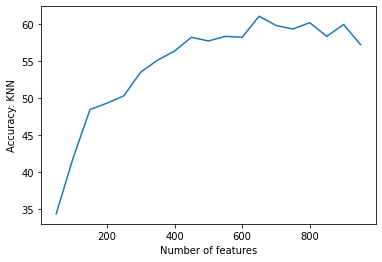

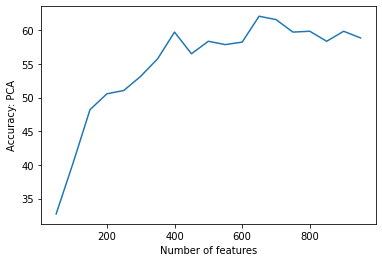

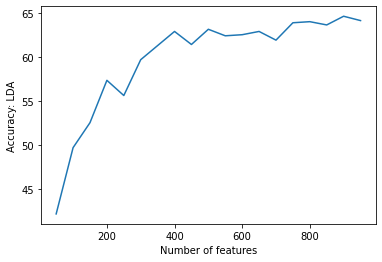

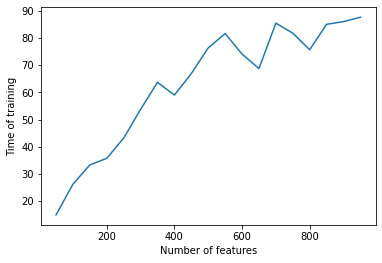

In [20]:
import matplotlib.pyplot as plt

plt.plot(features,accuracy_knn)
plt.ylabel('Accuracy: KNN')
plt.xlabel('Number of features')
plt.show()

plt.plot(features,accuracy_pca)
plt.ylabel('Accuracy: PCA')
plt.xlabel('Number of features')
plt.show()

plt.plot(features,accuracy_lda)
plt.ylabel('Accuracy: LDA')
plt.xlabel('Number of features')
plt.show()

plt.plot(features,train_time)
plt.ylabel('Time of training')
plt.xlabel('Number of features')
plt.show()

We can see that if we increment the amount of features, the performance is better, but the computational time it's to longer,
because the computer needs more memory to store all the descriptors values.

Now we will vary the metric used while building the K-NN classifier. In this section we will use the following metrics and compare them: Euclidean (base case), Manhattan, and Chebyshev

In [18]:
knn = KNeighborsClassifier(n_neighbors=5,n_jobs=-1,metric='euclidean')
knn.fit(visual_words, train_labels) 
knn_manhattan = KNeighborsClassifier(n_neighbors=5,n_jobs=-1,metric='manhattan')
knn_manhattan.fit(visual_words, train_labels)
knn_chebyshev = KNeighborsClassifier(n_neighbors=5,n_jobs=-1,metric='chebyshev')
knn_chebyshev.fit(visual_words, train_labels)

accuracy = 100*knn.score(visual_words_test, test_labels)
print('Eucliedean:')
print(accuracy)
accuracy = 100*knn_manhattan.score(visual_words_test, test_labels)
print('Manhattan:')
print(accuracy)
accuracy = 100*knn_chebyshev.score(visual_words_test, test_labels)
print('Chebyshev:')
print(accuracy)

Eucliedean:
57.74473358116481
Manhattan:
55.88599752168525
Chebyshev:
47.95539033457249


Similarly, we also check the variations on the metric used when applying Dimensionality Reduction with PCA

In [19]:
pca = PCA(n_components=64)
VWpca = pca.fit_transform(visual_words)
knnpca = KNeighborsClassifier(n_neighbors=5,n_jobs=-1,metric='euclidean')
knnpca.fit(VWpca, train_labels)
vwtestpca = pca.transform(visual_words_test)
accuracy = 100*knnpca.score(vwtestpca, test_labels)
print('Euclidean:')
print(accuracy)

knnpca = KNeighborsClassifier(n_neighbors=5,n_jobs=-1,metric='manhattan')
knnpca.fit(VWpca, train_labels)
accuracy = 100*knnpca.score(vwtestpca, test_labels)
print('Manhattan:')
print(accuracy)

knnpca = KNeighborsClassifier(n_neighbors=5,n_jobs=-1,metric='chebyshev')
knnpca.fit(VWpca, train_labels)
accuracy = 100*knnpca.score(vwtestpca, test_labels)
print('Chebyshev:')
print(accuracy)

Euclidean:
58.116480793060724
Manhattan:
55.39033457249071
Chebyshev:
57.49690210656754


And we also check what happens when applying Dimensionality Reduction with LDA

In [20]:
lda = LinearDiscriminantAnalysis()
VWlda = lda.fit_transform(visual_words,train_labels)

knnlda = KNeighborsClassifier(n_neighbors=5,n_jobs=-1,metric='euclidean')
knnlda.fit(VWlda, train_labels) 
vwtestlda = lda.transform(visual_words_test)
accuracy = 100*knnlda.score(vwtestlda, test_labels)
print('Euclidean:')
print(accuracy)

knnlda = KNeighborsClassifier(n_neighbors=5,n_jobs=-1,metric='manhattan')
knnlda.fit(VWlda, train_labels) 
accuracy = 100*knnlda.score(vwtestlda, test_labels)
print('Manhattan:')
print(accuracy)

knnlda = KNeighborsClassifier(n_neighbors=5,n_jobs=-1,metric='chebyshev')
knnlda.fit(VWlda, train_labels) 
accuracy = 100*knnlda.score(vwtestlda, test_labels)
print('Chebyshev:')
print(accuracy)

Euclidean:
62.70136307311029
Manhattan:
62.825278810408925
Chebyshev:
60.594795539033456


Without reducing dimensionality, we can see that varying the distance metrics used produces different results. In this scenario, Euclidean distance has worked the best since it takes into account the real distance between a pair of points. Manhattan distance has ranked second between the three metrics tested, this is probably due to Manhattan distance being the shortest of all the possible 'routes' inside a grid to get from point A to point B. Chebyshev distance has ranked last producing the lowest accuracy out of all the metrics used, therefore we can conclude that for bigger dimensionalities.

When reducing dimensionality using PCA, we observe that the not only that the ranking remains unchanged but also that clustering has now produced better results thus increasing the accuracy.

Finally, when reducing dimensionality using LDA we notice some interesting changes. Not only has the results improved accross the board, but also the gap between the results produced by the different metrics has shortened. Another noticeable change is that the ranking has shifted with Chebyshev performing the best out of all the metrics tested, although the diference in performance is not significant in this scenario.

In [29]:

%reset -f
import cv2
import numpy as np
import time
import _pickle as cPickle
import random
from sklearn.cluster import MiniBatchKMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

train_images_filenames = cPickle.load(open('train_images_filenames.dat','rb'))
test_images_filenames = cPickle.load(open('test_images_filenames.dat','rb'))
train_labels = cPickle.load(open('train_labels.dat','rb'))
test_labels = cPickle.load(open('test_labels.dat','rb'))

all_images_filenames = train_images_filenames + test_images_filenames
all_images_labels = train_labels+test_labels
categories = ['coast','forest','highway','inside_city','mountain','Opencountry','street','tallbuilding']

set1_filenames = []
set2_filenames = []
set3_filenames = []

set1_labels = []
set2_labels = []
set3_labels = []
c = list(zip(all_images_filenames, all_images_labels))
random.shuffle(c)
a,b = zip(*c)
for cat in categories:
    filename_matches = [s for s in all_images_filenames if cat in s]
    label_matches = [s for s in all_images_labels if cat in s]
    c = list(zip(filename_matches,label_matches))
    random.shuffle(c)
    filename_matches,label_matches = zip(*c)
    print(len(filename_matches))
    print(len(label_matches))
    n_features = int(len(filename_matches)/3)

    set1_filenames.extend(filename_matches[0:n_features-1])
    set1_labels.extend(label_matches[0:n_features-1])

    set2_filenames.extend(filename_matches[n_features:(n_features * 2) - 1])
    set2_labels.extend(label_matches[n_features:(n_features * 2) - 1])

    set3_filenames.extend(filename_matches[n_features * 2:])
    set3_labels.extend(label_matches[n_features * 2:])



360
360
328
328
260
260
308
308
374
374
410
410
292
292
356
356
['../../Databases/MIT_split/test/coast/land340.jpg', '../../Databases/MIT_split/train/coast/nat288.jpg', '../../Databases/MIT_split/test/coast/gre637.jpg', '../../Databases/MIT_split/train/forest/cdmc12.jpg', '../../Databases/MIT_split/train/forest/cdmc281.jpg', '../../Databases/MIT_split/train/forest/text105.jpg', '../../Databases/MIT_split/test/forest/natu994.jpg', '../../Databases/MIT_split/train/forest/nat867.jpg', '../../Databases/MIT_split/train/forest/nat205.jpg']
['coast', 'coast', 'coast', 'forest', 'forest', 'forest', 'forest', 'forest', 'forest']


'print(train_images_filenames)\nprint(train_labels)'